Task: Portfolio Optimisation with Linear Regression

Import Required Libraries

In [ ]:
!pip install yfinance --user
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers
import statsmodels.api as sm
import seaborn as sns

# 1.Data collection

In [ ]:
# Define the stock tickers
stocks = ["AAPL","AMT","AMZN", "GOOGL","JPM" ,"LIN","NEE","PG","RTX","UNH","XOM"]
market_index = "^GSPC"  # S&P 500
# Define time period
period = '5y'
# Download stock price data
stock_data = yf.download(stocks, period=period)["Close"]
# Download market index data
market_data = yf.download(market_index, period=period)["Close"]
# Calculate daily returns
stock_returns = stock_data.pct_change().dropna()
market_returns = market_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  1 of 1 completed


# 2.Linear regression for expected returns and risk

In [ ]:
# Perform linear regression to estimate alpha (α) and beta (β)

# Define risk-free rate
# Convert to daily by dividing 252 (trading days)
rf = 0.02/ 252

# Compute excess returns
#Ri − Rf
ticker_excess_returns = stock_returns - rf
#Rm − Rf
market_excess_return = market_returns - rf
#initial variable
betas = {}
alphas = {}
idiosyncratic_variances = {}
alpha_pvalue = {}
beta_pvalue = {}
r_squared = {}
expected_returns = {}
average_market_return = market_returns['^GSPC'].mean()

for stock in stocks:
    X = sm.add_constant(market_excess_return)  # Add constant term for alpha
    y = ticker_excess_returns[stock]
    model = sm.OLS(y, X)
    result = model.fit()
    alphas[stock] = result.params[0]
    betas[stock] = result.params[1]
    residuals = result.resid  # Compute residuals (ϵi)
    idiosyncratic_variances[stock] = residuals.var() #Idiosyncratic Variance
    # Store statistical significance and model fit
    alpha_pvalue[stock] = result.pvalues[0]
    beta_pvalue[stock] = result.pvalues[1]
    r_squared[stock] = result.rsquared
    # Compute expected return using CAPM formula
    expected_returns[stock] = rf + betas[stock] * (average_market_return - rf)

# Create a dataframe with the results
capm_results = pd.DataFrame({
    'Alpha (Daily)': [alphas[stock] for stock in stocks],
    'p-value (α)': [alpha_pvalue[stock] for stock in stocks],
    'Beta': [betas[stock] for stock in stocks],
    'p-value (β)': [beta_pvalue[stock] for stock in stocks],
    'R²': [r_squared[stock] for stock in stocks],
    'Idiosyncratic Variance': [idiosyncratic_variances[stock] for stock in stocks],
    'Expected Return': [expected_returns[stock] for stock in stocks]
}, index=stocks)

# Format p-values
def format_p_value(p):
    if p < 0.001:
        return "<0.001"
    else:
        return "{:.3f}".format(p)
capm_results['p-value (α)'] = capm_results['p-value (α)'].apply(format_p_value)
capm_results['p-value (β)'] = capm_results['p-value (β)'].apply(format_p_value)

# Print the formatted table
print("CAPM Regression Results")
print("======================")
print(capm_results)
capm_results.to_csv('output_file.csv', index=False)

CAPM Regression Results
       Alpha (Daily) p-value (α)      Beta p-value (β)        R²  \
AAPL        0.000465       0.186  1.152242      <0.001  0.593377   
AMT        -0.000365       0.414  0.845539      <0.001  0.326968   
AMZN        0.000141       0.772  1.115947      <0.001  0.416069   
GOOGL       0.000283       0.470  1.148665      <0.001  0.538095   
JPM         0.000361       0.376  1.054346      <0.001  0.475406   
LIN         0.000362       0.235  0.890291      <0.001  0.536435   
NEE        -0.000190       0.676  0.799880      <0.001  0.295696   
PG          0.000126       0.688  0.516584      <0.001  0.268556   
RTX         0.000133       0.775  0.917041      <0.001  0.344308   
UNH         0.000152       0.725  0.782227      <0.001  0.308254   
XOM         0.000627       0.229  0.779813      <0.001  0.232580   

       Idiosyncratic Variance  Expected Return  
AAPL                 0.000154         0.000767  
AMT                  0.000250         0.000584  
AMZN        

<ipython-input-5-3e7a6e46505d>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alphas[stock] = result.params[0]
<ipython-input-5-3e7a6e46505d>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[stock] = result.params[1]
<ipython-input-5-3e7a6e46505d>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_pvalue[stock] = result.pvalues[0]
<ipython-input-5-3e7a6e46505d>:33: FutureWarning: Series.__getitem__ treating keys as po

  * 2.1 Visualization



In [ ]:
def plot_capm_regression(market_excess_return, ticker_excess_returns, alphas, betas, ticker):
    """
    Plots the CAPM regression for a given asset.

    Parameters:
    market_excess_return (array-like): Market excess returns.
    ticker_excess_returns (dict): Dictionary containing excess returns for various assets.
    alphas (dict): Dictionary containing alpha values for assets.
    betas (dict): Dictionary containing beta values for assets.
    ticker (str): The asset ticker to plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(market_excess_return, ticker_excess_returns[ticker], alpha=0.5, label='Daily Excess Returns')
    plt.plot(market_excess_return, alphas[ticker] + betas[ticker] * market_excess_return,
             color='red', label=f'CAPM Regression (β={betas[ticker]:.2f})')
    plt.xlabel('Market Excess Return')
    plt.ylabel(f'{ticker} Excess Return')
    plt.title(f'CAPM Regression for {ticker}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{ticker.lower()}_regression.png')
    plt.show()

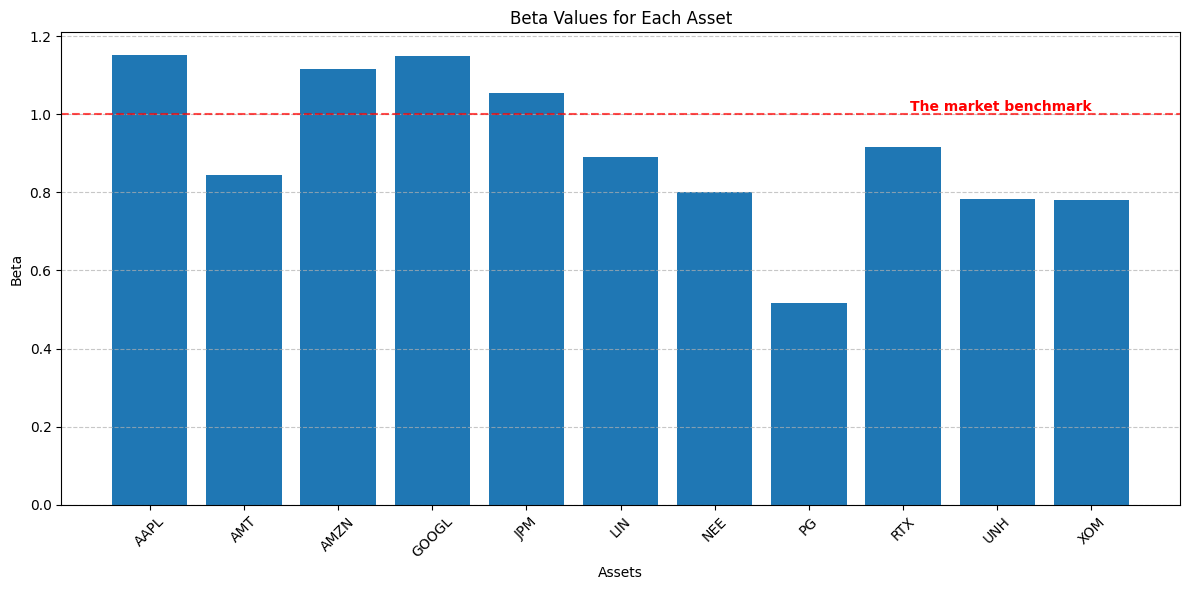

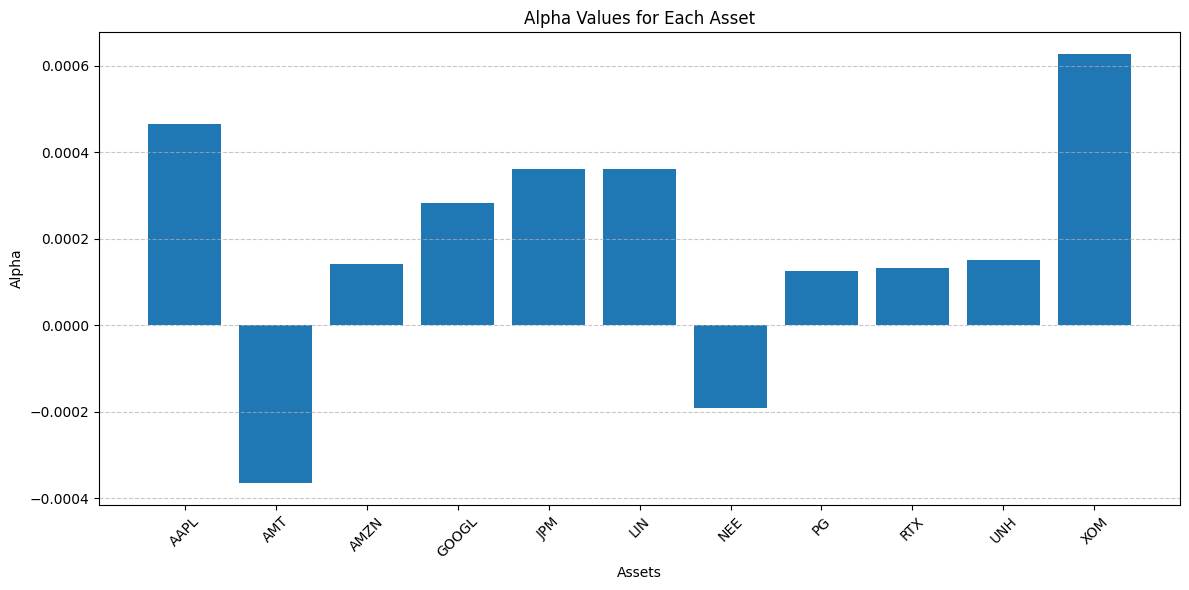

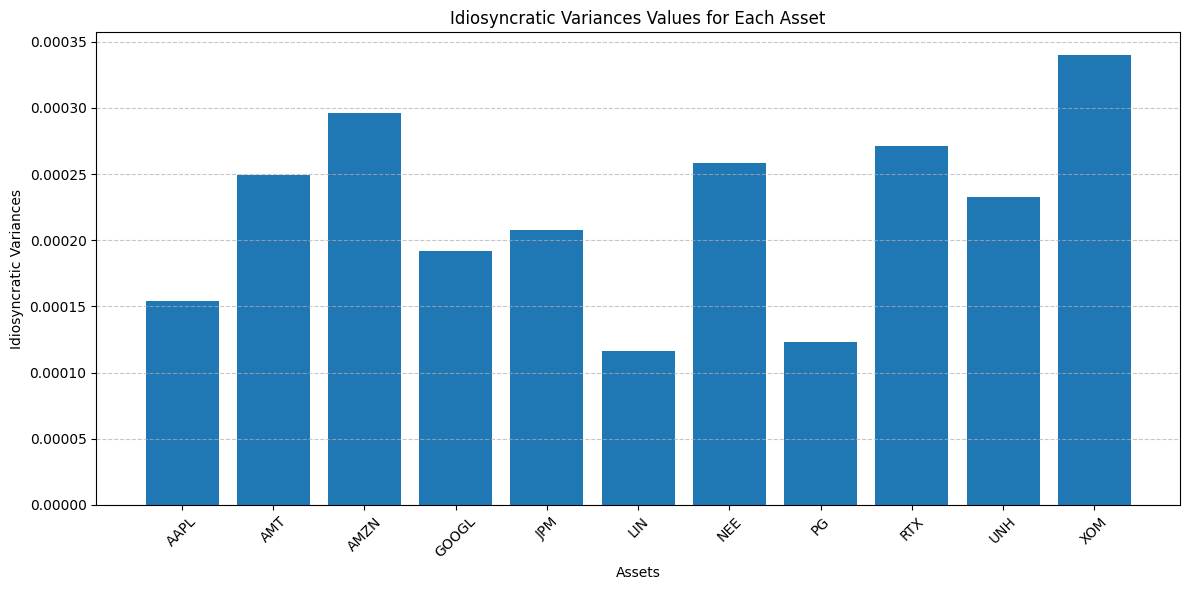

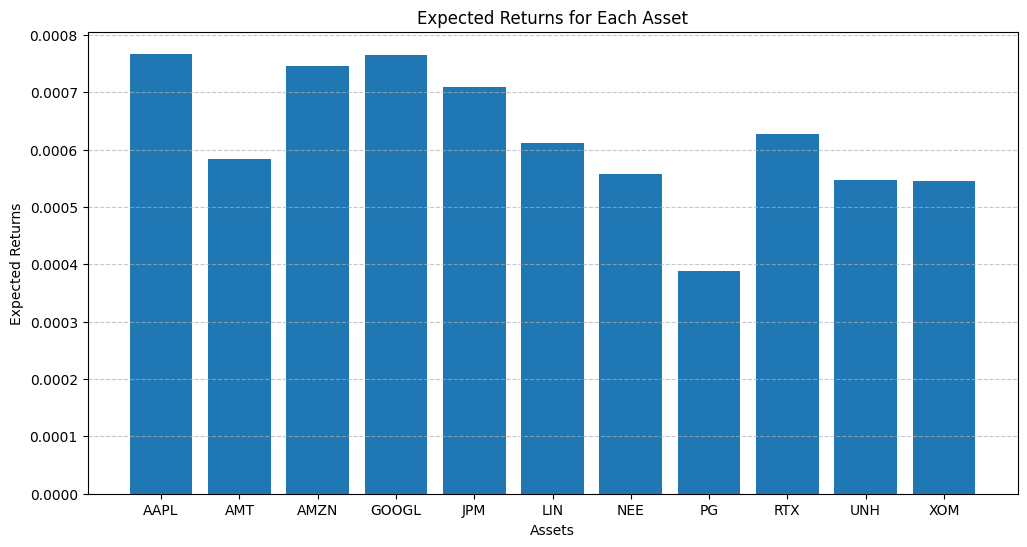

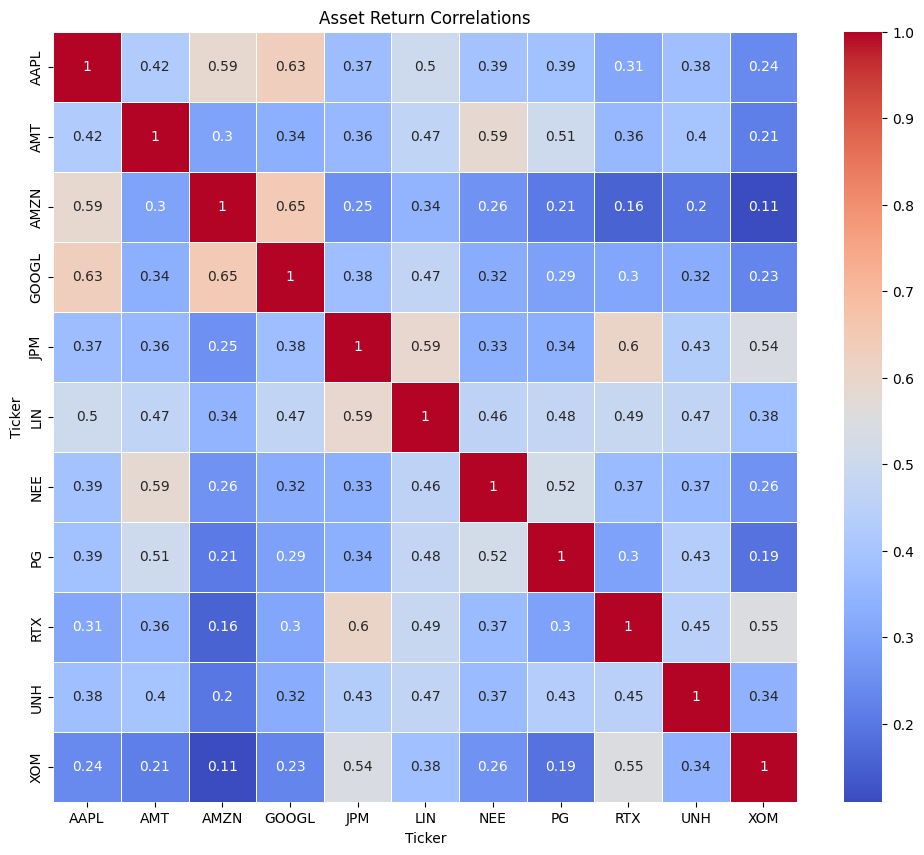

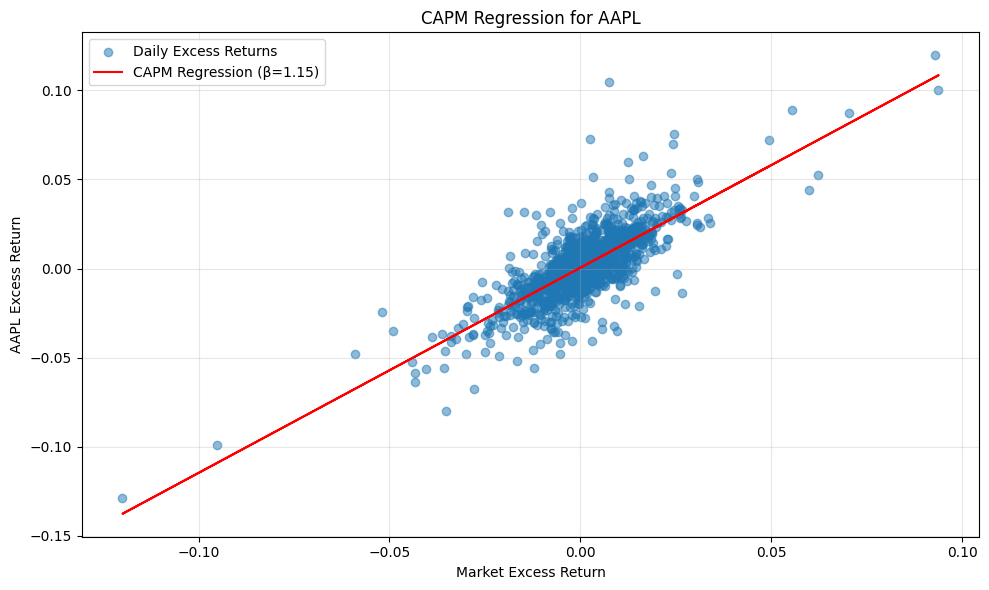

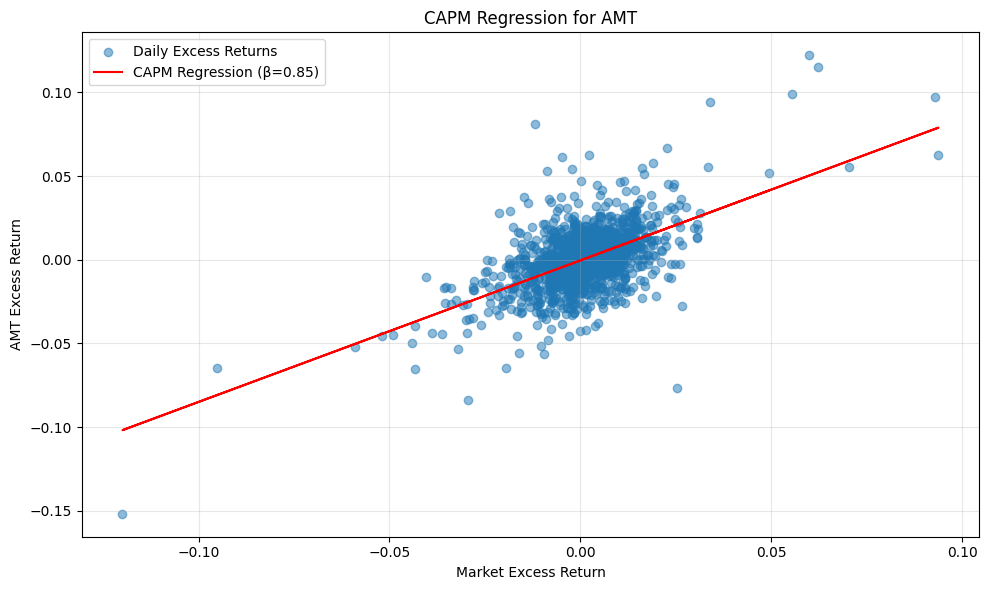

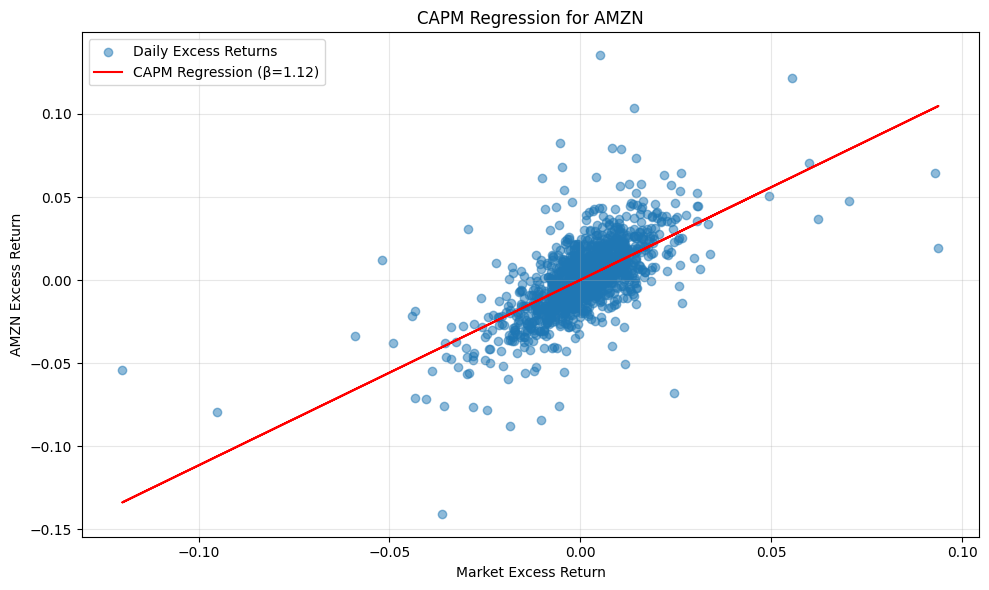

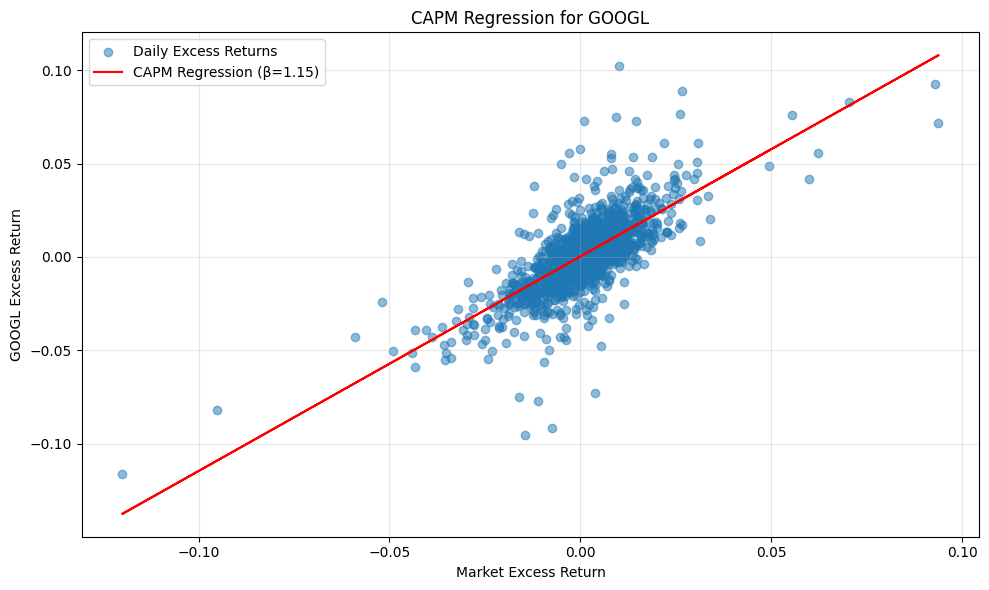

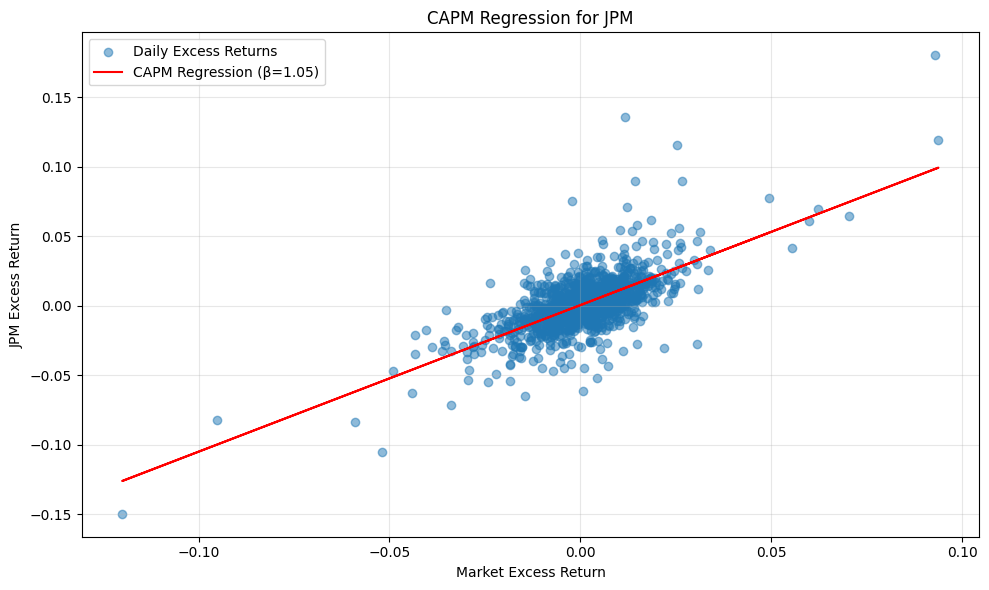

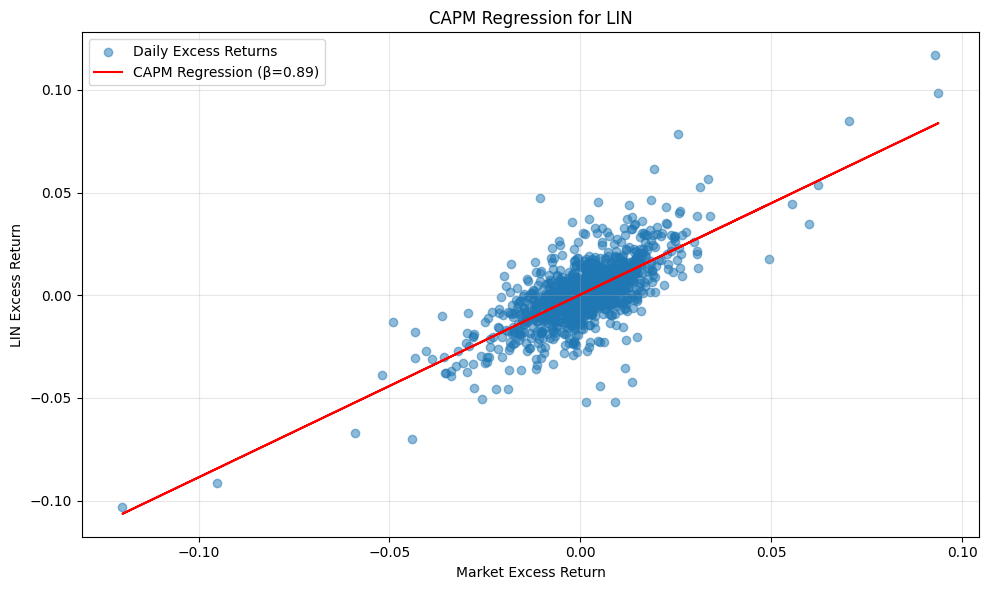

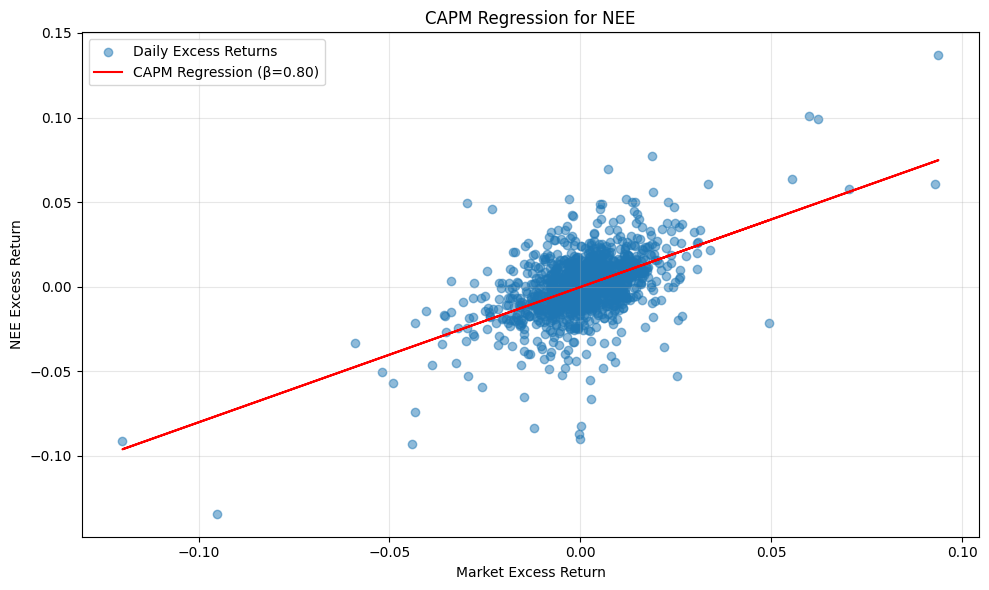

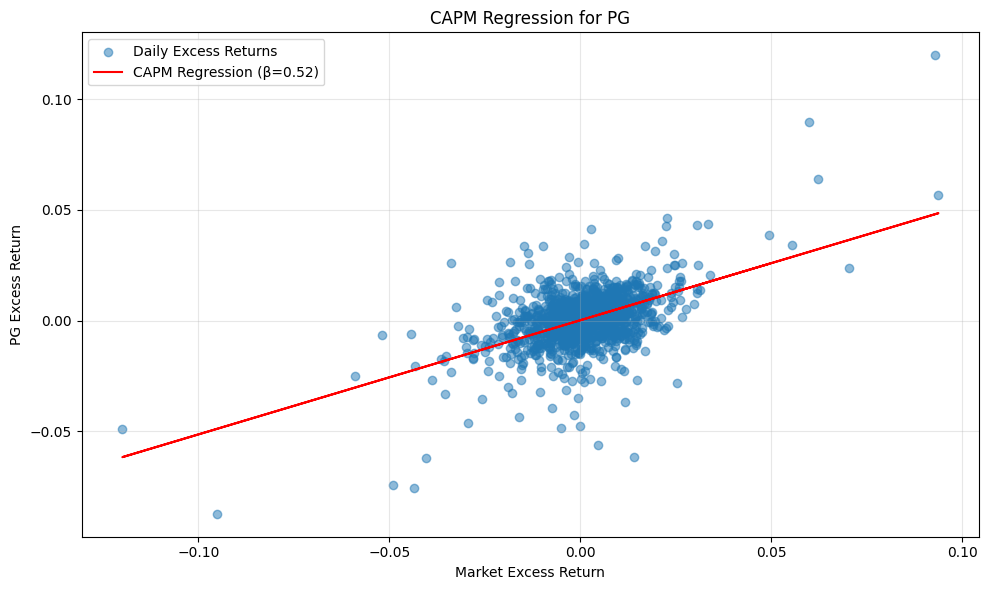

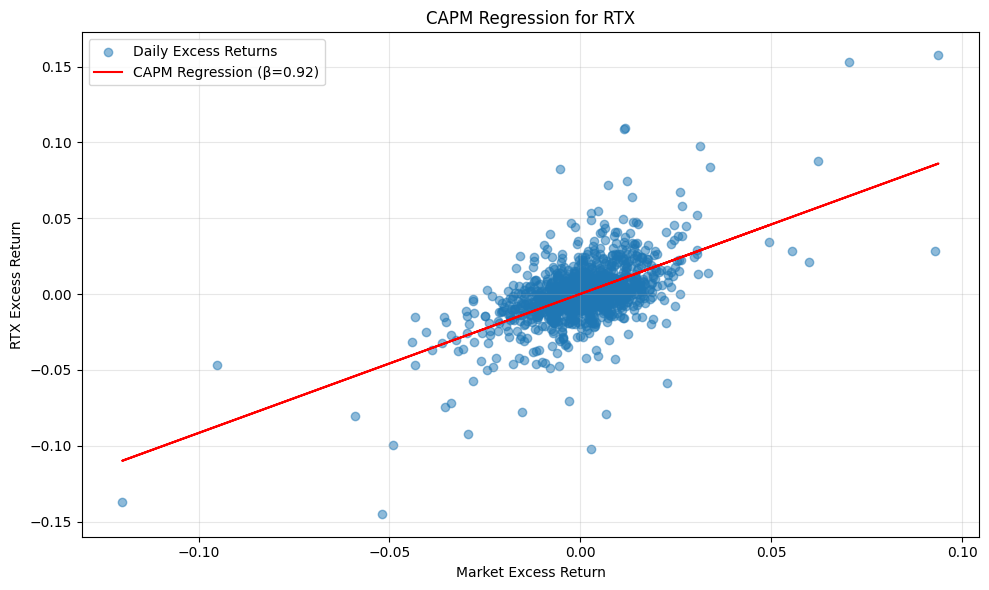

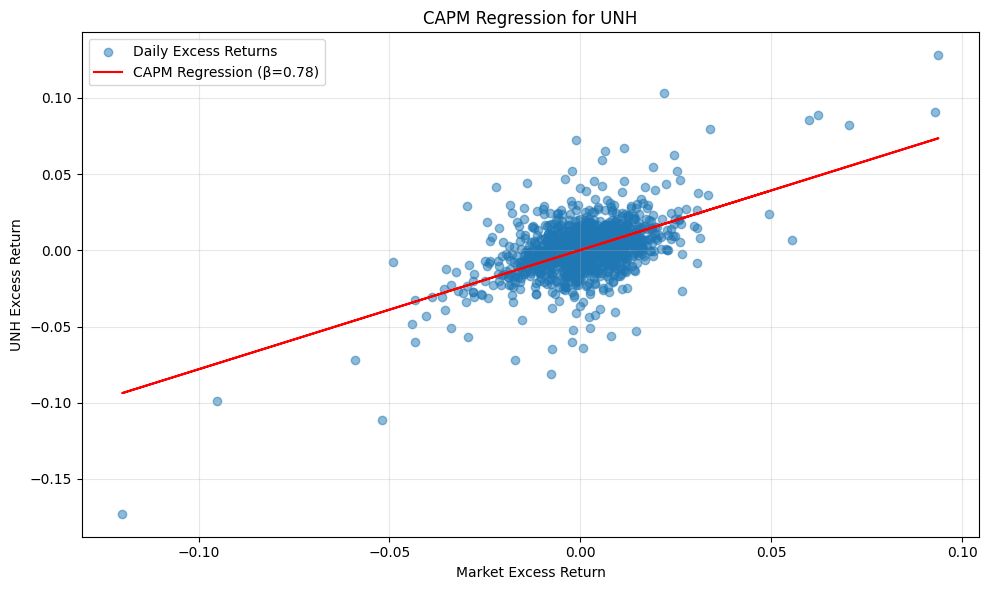

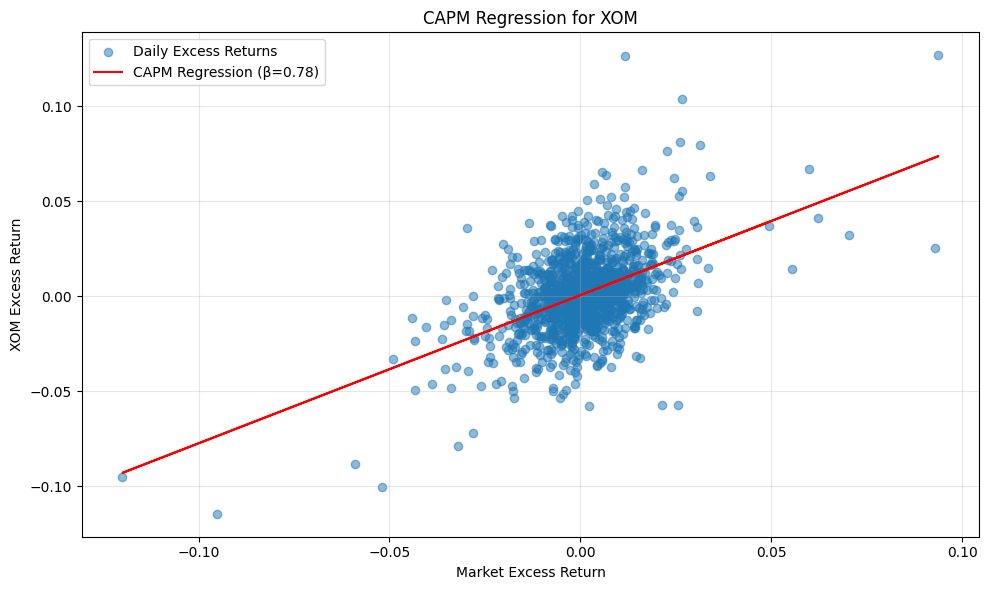

In [ ]:
# Create visualization for Beta comparison
plt.figure(figsize=(12, 6))
plt.bar(stocks, [betas[stock] for stock in stocks])
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
plt.text(len(betas)-1, 1, 'The market benchmark',
         color='r', ha='right', va='bottom', fontweight='bold')
plt.xlabel('Assets')
plt.ylabel('Beta')
plt.title('Beta Values for Each Asset')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('beta_comparison.png')

# Create visualization for Alpha comparison
plt.figure(figsize=(12, 6))
plt.bar(stocks, [alphas[stock] for stock in stocks])
plt.xlabel('Assets')
plt.ylabel('Alpha')
plt.title('Alpha Values for Each Asset')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('alpha_comparison.png')

# Create visualization for idiosyncratic_variances comparison
plt.figure(figsize=(12, 6))
plt.bar(stocks, [idiosyncratic_variances[stock] for stock in stocks])
plt.xlabel('Assets')
plt.ylabel('Idiosyncratic Variances')
plt.title('Idiosyncratic Variances Values for Each Asset')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('idiosyncratic_variances.png')

# Create visualization for expected_returns comparison
plt.figure(figsize=(12, 6))
plt.bar(stocks, [expected_returns[stock] for stock in stocks])
plt.xlabel('Assets')
plt.ylabel('Expected Returns')
plt.title('Expected Returns for Each Asset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('expected_returns.png')

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = stock_returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Asset Return Correlations')
plt.savefig('correlation_heatmap.png')
plt.show()

# plots the CAPM regression for a given asset.
for stock in stocks:
  plot_capm_regression(market_excess_return,ticker_excess_returns,alphas,betas,stock)

# 3.Portfolio optimisation
  * Construct the Covariance MatrixList
  * Formulate the Quadratic Programming Problem
  * Display Portfolio Weights

In [ ]:
# Compute market variance (σ²_m)
market_variance = np.var(market_returns)
# Construct covariance matrix
num_assets = len(stocks)
cov_matrix = np.zeros((num_assets, num_assets))
for i in range(num_assets):
    for j in range(num_assets):
        if i == j:
            # Diagonal element: systematic + idiosyncratic risk
            cov_matrix[i, j] = betas[stocks[i]]**2 * market_variance + idiosyncratic_variances[stocks[i]]
        else:
            # Off-diagonal element: systematic risk only
            cov_matrix[i, j] = betas[stocks[i]] * betas[stocks[j]] * market_variance

# Convert to DataFrame
cov_matrix_df = pd.DataFrame(cov_matrix, index=stocks, columns=stocks)
print(cov_matrix_df)

           AAPL       AMT      AMZN     GOOGL       JPM       LIN       NEE  \
AAPL   0.000379  0.000165  0.000218  0.000224  0.000206  0.000174  0.000156   
AMT    0.000165  0.000371  0.000160  0.000165  0.000151  0.000128  0.000115   
AMZN   0.000218  0.000160  0.000507  0.000217  0.000199  0.000168  0.000151   
GOOGL  0.000224  0.000165  0.000217  0.000416  0.000205  0.000173  0.000156   
JPM    0.000206  0.000151  0.000199  0.000205  0.000396  0.000159  0.000143   
LIN    0.000174  0.000128  0.000168  0.000173  0.000159  0.000250  0.000121   
NEE    0.000156  0.000115  0.000151  0.000156  0.000143  0.000121  0.000367   
PG     0.000101  0.000074  0.000098  0.000101  0.000092  0.000078  0.000070   
RTX    0.000179  0.000131  0.000173  0.000178  0.000164  0.000138  0.000124   
UNH    0.000153  0.000112  0.000148  0.000152  0.000140  0.000118  0.000106   
XOM    0.000152  0.000112  0.000147  0.000152  0.000139  0.000118  0.000106   

             PG       RTX       UNH       XOM  
AAP

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
<ipython-input-8-97a753e24bcb>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cov_matrix[i, j] = betas[stocks[i]]**2 * market_variance + idiosyncratic_variances[stocks[i]]
<ipython-input-8-97a753e24bcb>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cov_matrix[i, j] = betas[stocks[i]] * betas[stocks[j]] * market_variance


In [ ]:

def optimize_portfolio(returns, cov_matrix, target_return):
    """
    Solve the quadratic programming problem for a given target return.
    """
    num_assets = len(returns)

    # Convert inputs to matrices
    P = matrix(cov_matrix)  # Objective: covariance matrix
    q = matrix(np.zeros(num_assets))  # Linear term

    # Constraints
    G = matrix(-np.eye(num_assets))  # w >= 0
    h = matrix(np.zeros(num_assets))

    A = matrix(np.vstack((np.ones(num_assets), returns)))  # Sum of weights = 1, expected return constraint
    b = matrix([1.0, target_return])

    # Solve quadratic program
    solvers.options['show_progress'] = False  # Hide solver output
    sol = solvers.qp(P, q, G, h, A, b)

    return np.array(sol['x']).flatten()

In [ ]:

def display_optimal_weights_with_risk_and_return(weights, tickers, target_return, portfolio_risk):
    """
    Display optimal portfolio weights with portfolio risk and target return as the last row.

    Parameters:
    weights (ndarray): Optimal portfolio weights
    tickers (list): List of asset tickers
    target_return (float): Target portfolio return
    covariance_matrix (ndarray): Covariance matrix of asset returns
    """
    # Sort weights in descending order
    sorted_indices = np.argsort(weights)[::-1]
    sorted_weights = weights[sorted_indices]
    sorted_tickers = [tickers[i] for i in sorted_indices]

    # Create a DataFrame for the portfolio weights
    portfolio_table = pd.DataFrame({
        'Asset': sorted_tickers,
        'Weight': sorted_weights
    })

    # Display the table
    print(f"\nOptimal Portfolio Weights (Target Return: {target_return:.6})")
    print(f"Portfolio Risk (Standard Deviation): {portfolio_risk:.6}")
    print(portfolio_table)

    return portfolio_table, portfolio_risk, target_return


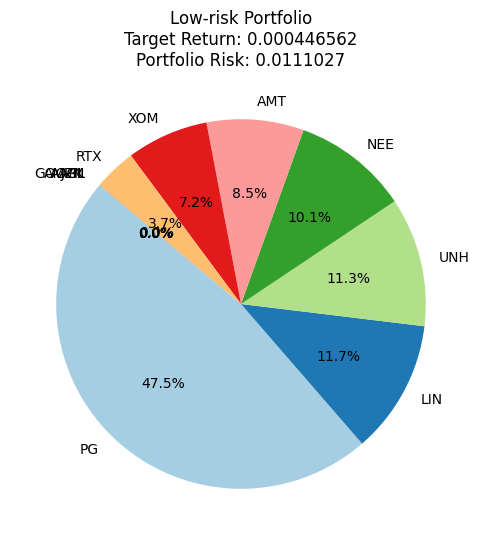

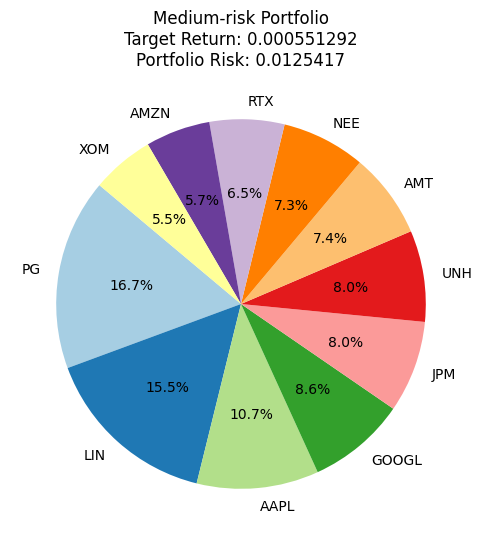

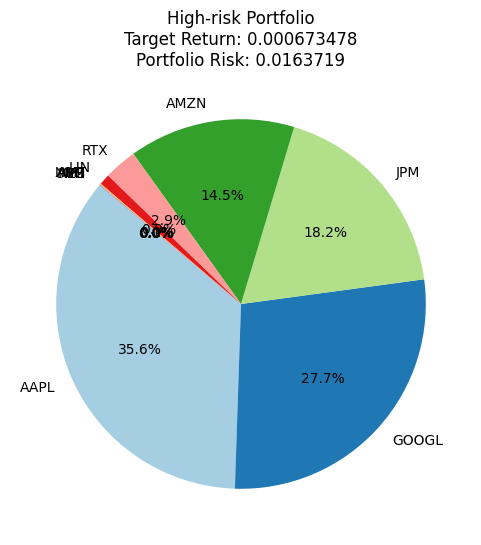

In [ ]:
def plot_pie_chart(weights, title, target_return, portfolio_risk):
    """
    Plots a pie chart to visualize portfolio weights.

    Parameters:
    weights (dict): A dictionary where keys are asset names and values are their corresponding weights.
    title (str): The title of the pie chart, typically the portfolio name.
    target_return (float): The expected return of the portfolio.
    portfolio_risk (float): The calculated risk (standard deviation) of the portfolio.
    """
    labels = list(weights.keys())
    sizes = list(weights.values())

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,colors=plt.cm.Paired.colors)
    plt.title(f"{title}\nTarget Return: {target_return}\nPortfolio Risk: {portfolio_risk}")
    plt.savefig(f'{title}.png')
    plt.show()

# Portfolio Weights
low_risk_weights = {"PG": 0.474799, "LIN": 0.117079, "UNH": 0.113056, "NEE": 0.101232, "AMT": 0.084925,
                    "XOM": 0.071608, "RTX": 0.036833, "JPM": 0.000275, "AMZN": 0.000133, "GOOGL": 0.000033, "AAPL": 0.000026}
medium_risk_weights = {"PG": 0.167431, "LIN": 0.155080, "AAPL": 0.106722, "GOOGL": 0.086018, "JPM": 0.080361, "UNH": 0.079878,
                       "AMT": 0.074488, "NEE": 0.073205, "RTX": 0.065432, "AMZN": 0.056608, "XOM": 0.054777}
high_risk_weights = {"AAPL": 0.355828, "GOOGL": 0.276629, "JPM": 0.182207, "AMZN": 0.145460, "RTX": 0.028783, "LIN": 0.009383,
                     "AMT": 0.000648, "XOM": 0.000385, "NEE": 0.000316, "UNH": 0.000294, "PG": 0.000066}
# Plotting the charts
plot_pie_chart(low_risk_weights, "Low-risk Portfolio", target_return=0.000446562, portfolio_risk=0.0111027)
plot_pie_chart(medium_risk_weights, "Medium-risk Portfolio", target_return=0.000551292, portfolio_risk=0.0125417)
plot_pie_chart(high_risk_weights, "High-risk Portfolio", target_return=0.000673478, portfolio_risk=0.0163719)

# 4.Efficient Frontier


Optimal Portfolio Weights (Target Return: 0.00038773)
Portfolio Risk (Standard Deviation): 0.0129784
    Asset        Weight
0      PG  1.000000e+00
1     RTX  1.774526e-09
2     LIN  1.456970e-09
3     JPM  8.933288e-10
4     AMT  6.165855e-10
5     NEE -1.867919e-10
6     XOM -2.047936e-10
7     UNH -2.247637e-10
8    AMZN -3.955915e-10
9   GOOGL -1.167430e-09
10   AAPL -1.253477e-09

Optimal Portfolio Weights (Target Return: 0.000407701)
Portfolio Risk (Standard Deviation): 0.0121337
    Asset    Weight
0      PG  0.875581
1     UNH  0.056423
2     XOM  0.041132
3     NEE  0.026413
4     AMT  0.000366
5     LIN  0.000039
6     RTX  0.000024
7     JPM  0.000007
8    AMZN  0.000005
9   GOOGL  0.000005
10   AAPL  0.000005

Optimal Portfolio Weights (Target Return: 0.000427672)
Portfolio Risk (Standard Deviation): 0.0115288
    Asset    Weight
0      PG  0.756821
1     UNH  0.092878
2     XOM  0.065467
3     NEE  0.065244
4     AMT  0.018293
5     LIN  0.000918
6     RTX  0.000321
7   

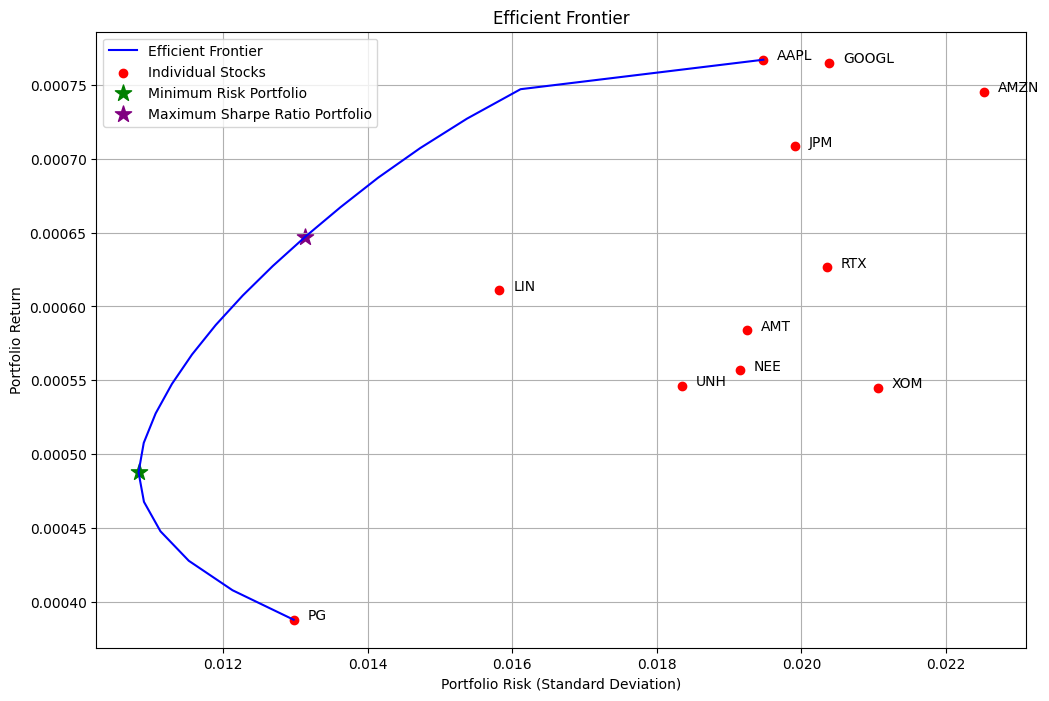

In [ ]:
# Define the range of target returns (µp) from the minimum to maximum expected return
min_return = min(expected_returns.values())
max_return = max(expected_returns.values())

target_returns_range = np.linspace(min_return, max_return, 20)  # 20 equally spaced target returns
# Store results for plotting
portfolio_risks = []
portfolio_returns = []

# Compute optimal portfolio and risk for each target return
for target_return in target_returns_range:

    optimal_weights = optimize_portfolio(list(expected_returns.values()),cov_matrix,target_return)  # Optimal portfolio weights

    # Compute portfolio return
    portfolio_return = np.dot(optimal_weights, list(expected_returns.values()))

    # Compute portfolio risk (standard deviation)
    portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

    portfolio_risks.append(portfolio_risk)
    portfolio_returns.append(portfolio_return)

    display_optimal_weights_with_risk_and_return(optimal_weights, stocks, portfolio_return,portfolio_risk)

# Calculate individual asset risks
asset_risks = np.sqrt(np.diagonal(cov_matrix))
asset_returns = list(expected_returns.values())

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(portfolio_risks, portfolio_returns, label="Efficient Frontier", color="blue")
plt.scatter(asset_risks, asset_returns, c='red', marker='o',label='Individual Stocks')

# Find minimum risk portfolio
min_var_idx = np.argmin(portfolio_risks)
plt.scatter(portfolio_risks[min_var_idx], portfolio_returns[min_var_idx],
                c='green', marker='*', s=150, label='Minimum Risk Portfolio')

# Find maximum Sharpe ratio portfolio (assuming risk-free rate of 0.02/252)
risk_free_rate = 0.02/252
sharpe_ratios = (np.asarray(portfolio_returns) - risk_free_rate) / portfolio_risks
max_sharpe_idx = np.argmax(sharpe_ratios)
plt.scatter(portfolio_risks[max_sharpe_idx], portfolio_returns[max_sharpe_idx],
                c='purple', marker='*', s=150, label='Maximum Sharpe Ratio Portfolio')

# Label individual assets
for i, ticker in enumerate(stocks):
  plt.annotate(ticker, (asset_risks[i], asset_returns[i]),
               xytext=(10, 0), textcoords='offset points')


plt.title("Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")
plt.grid(True)
plt.legend()
plt.savefig('Efficient_Frontier.png')
plt.show()
